# Connect to google account

In [313]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount("/content/data")

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [314]:
!pip install category_encoders

In [315]:
# 모듈 Import
import random
import numpy as np # 행렬 계산에 사용하는 모듈
import pandas as pd # 데이터 처리와 분석을 위한 모듈
import matplotlib.pyplot as plt # 데이터 시각화를 위한 모듈. 2D, 3D 그릴 때 사용
import seaborn as sns # 데이터 시각화를 위한 모듈. 두 데이터의 관계를 볼때 사용
from datetime import datetime, timedelta
from tqdm.auto import tqdm
import category_encoders as ce
from sklearn.metrics.pairwise import cosine_similarity

In [316]:
# 딕셔너리를 간편하게 사용하는 것을 도와준다. 모델 class 처럼 사용 가능
# dot을 이용해 객체를 불러 사용. JSON 다룰때 유용.
import easydict
args = easydict.EasyDict()

# path
args.default_path = "/content/data/MyDrive/Playdata/Competitions/ML/Dacon/" # 메인 경로
args.apply_train_path = args.default_path + "apply_train.csv" # train 데이터 경로
args.company_path = args.default_path + "company.csv"
args.recruitment_path = args.default_path + "recruitment.csv"
args.resume_certificate_path = args.default_path + "resume_certificate.csv"
args.resume_education_path = args.default_path + "resume_education.csv"
args.resume_language_path = args.default_path + "resume_language.csv"
args.resume_path = args.default_path + "resume.csv"

args.default_submission_path = args.default_path + "sample_submission.csv" # 예측결과(제출파일) 경로

# 데이터 분석을 위한 변수들
# # 난수 생성 제어 => 같은 코드를 실행해도 동일한 결과를 얻기 위해서 설정
# 데이터 분할 및 모델 초기화 때 유용.
args.random_state = 42
args.results = [] # 결과 저장 리스트

In [317]:
args.submission_path = args.default_path + "result/submission_20231110.csv" # 결과 저장 파일
args.save_results = args.default_path+"result/model_results_20231110.json" # 결과 저장 json

# 함수정의

In [318]:
def recall5(answer_df, submission_df):

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # submission의 예측이 각각 5개인지 확인
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # submission의 예측된 값들에 null값이 있는지 확인
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # 예측값에 중복이 있는지 확인
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    # primary_col 즉 resume_seq가 양측에 있는지 확인 후 남김
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    #
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    #recall = np.mean(individual_recalls)
    recall = max(individual_recalls)
    return recall

# File Load

In [319]:
apply_train_df = pd.read_csv(args.apply_train_path) # apply_train -> DataFrame화
company_df = pd.read_csv(args.company_path) # company -> DataFrame화
recruitment_df = pd.read_csv(args.recruitment_path) # recruitment -> DataFrame화
resume_certificate_df = pd.read_csv(args.resume_certificate_path) # resume_certificate -> DataFreame화
resume_education_df = pd.read_csv(args.resume_education_path) # resume_education -> DataFrame화
resume_language_df = pd.read_csv(args.resume_language_path) # resume_language -> DataFrame화
resume_df = pd.read_csv(args.resume_path) # resume -> DataFrame화


In [320]:
apply_train = apply_train_df.copy()
company = company_df.copy()
recruitment = recruitment_df.copy()
resume_certificate = resume_certificate_df.copy()
resume_education = resume_education_df.copy()
resume_language = resume_language_df.copy()
resume = resume_df.copy()

# 탐색

### merged_recruitment 생성

In [321]:
# recruitment, company 정렬(recruitment_seq 기준)
company = company.sort_values(by = "recruitment_seq")
recruitment = recruitment.sort_values(by = "recruitment_seq")

In [322]:
# merged_recruitment = recruitment, company merge
merged_recruitment = pd.merge(recruitment, company, on='recruitment_seq', how='left')
merged_recruitment

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


### merged_recruitment 탐색 & drop

In [323]:
(merged_recruitment.isnull().sum() / len(merged_recruitment)).sort_values()

recruitment_seq      0.000000
career_end           0.000000
career_start         0.000000
check_box_keyword    0.000000
education            0.000000
major_task           0.000000
qualifications       0.000000
address_seq1         0.000149
company_type_seq     0.644959
supply_kind          0.644959
employee             0.644959
text_keyword         0.894399
address_seq2         0.985063
address_seq3         0.998656
dtype: float64

### merged_resume 생성

In [324]:
# resume 정렬 (resume_seq 기준)
resume = resume.sort_values(by='resume_seq')
resume.shape

(8482, 13)

In [325]:
# resume_certificate 정렬 (resume_seq 기준)
resume_certificate = resume_certificate.sort_values(by='resume_seq')
# certificate_contents에 결측값이 존재하는 행 제거
resume_certificate = resume_certificate.dropna(subset=['certificate_contents'])
# 이력서번호(resume_seq)기준으로 groupby
# 이력서번호(resume_seq)의 해당하는 자격증들을 세미콜론(;)으로 join해서 적용(apply)
resume_certificate = resume_certificate.groupby('resume_seq')['certificate_contents'].apply(';'.join).reset_index()
resume_certificate

,resume_seq,certificate_contents
0,U00002,자동차 운전면허 (2종 보통)
1,U00003,운전면허2종보통;컬러리스트 기사;워드프로세서 1급
2,U00004,정보처리기능사;유통관리사 2급;MOS EXCEL 2003 EXPERT
3,U00006,운전면허 1종 보통;문서실무사1급;유통관리사 2급
4,U00007,샵마스터;자동차운전면허1종 보통;패턴 양장 기능사;MICROSOFT OFFICE E...
...,...,...
5971,U08476,운전면허2종보통
5972,U08479,컴퓨터그래픽스운용기능사
5973,U08480,2종 보통 운전면허증;컴퓨터그래픽스운용기능사;컬러리스트기사;컴퓨터패션디자인운용마스터
5974,U08481,컴퓨터활용능력 2급


In [326]:
# resume_education 정렬 (resume_seq 기준)
resume_education = resume_education.sort_values(by='resume_seq')
resume_education.shape

(8482, 14)

In [327]:
# lanauge;exam_name;score값을 넣을 컬럼 생성
resume_language['lang_exam_score'] = resume_language['language'].astype(str) + ';' + resume_language['exam_name'].astype(str) + ';' + resume_language['score'].astype(str)
# 기존 lanauge, exam_name, score 컬럼 삭제
resume_language = resume_language.drop(['language','exam_name', 'score'], axis=1)

# lang_exam_score 결측값 제거
resume_language = resume_language.dropna(subset=['lang_exam_score'])
# 이력서번호(resume_seq)별 가지고 있는 자격증을 & 기준으로 join해서 적용(apply)
resume_language = resume_language.groupby('resume_seq')['lang_exam_score'].apply('&'.join).reset_index()
resume_language

,resume_seq,lang_exam_score
0,U00004,2;11;661.62
1,U00005,2;4;873.74
2,U00039,2;4;848.48
3,U00054,2;4;909.09
4,U00067,2;2;20.0
...,...,...
815,U08443,4;5;676.77
816,U08461,2;4;676.77
817,U08465,2;11;11.11
818,U08472,2;4;611.11


In [328]:
# merged_resume = resume, resume_certificate, resume_education, resume_language
merged_resume = pd.merge(resume, resume_certificate, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_education, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_language, on='resume_seq', how='left')
merged_resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,...,hischool_location_seq,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score,lang_exam_score
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,4,5,5,0,17,NaN,NaN,9,20.0,NaN
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,...,0,5,5,0,3,NaN,NaN,8,90.0,NaN
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,...,6,5,5,0,17,NaN,NaN,4,90.0,NaN
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,...,5,5,5,0,5,NaN,NaN,3,70.0,2;11;661.62
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,...,5,0,0,0,0,NaN,NaN,10,50.0,2;4;873.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,...,3,5,5,0,5,NaN,NaN,19,0.0,NaN
8478,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,...,3,3,6,0,3,가정과,NaN,9,0.0,NaN
8479,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,...,0,5,5,0,10,미술대학섬유패션코디네이션학과,NaN,9,80.0,NaN
8480,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,...,5,5,5,0,5,NaN,NaN,9,60.0,NaN


### merged_resume 탐색 & drop

In [329]:
(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.000000
univ_type_seq1           0.000000
hischool_location_seq    0.000000
hischool_gender          0.000000
hischool_nation          0.000000
hischool_special_type    0.000000
hischool_type_seq        0.000000
univ_score               0.000000
career_month             0.000000
univ_type_seq2           0.000000
univ_location            0.000000
job_code_seq1            0.000000
last_salary              0.000000
hope_salary              0.000000
graduate_date            0.000000
degree                   0.000000
updated_date             0.000000
reg_date                 0.000000
univ_major_type          0.000000
univ_transfer            0.000000
text_keyword             0.022990
career_job_code          0.089366
certificate_contents     0.295449
univ_major               0.788375
lang_exam_score          0.903325
job_code_seq2            0.941052
univ_sub_major           0.950955
job_code_seq3            0.977953
dtype: float64

## merged_total EDA

### merged_total 생성

In [330]:
#컬럼이 너무 많아 헷갈려서 recruitment 데이터에는 'rc_' 추가
rc_columns = ['rc_' + x for x in merged_recruitment.columns]
merged_recruitment.rename(columns=dict(zip(merged_recruitment.columns, rc_columns)), inplace=True)
merged_recruitment

,rc_recruitment_seq,rc_address_seq1,rc_address_seq2,rc_address_seq3,rc_career_end,rc_career_start,rc_check_box_keyword,rc_education,rc_major_task,rc_qualifications,rc_text_keyword,rc_company_type_seq,rc_supply_kind,rc_employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


In [331]:
#apply_train과 merged_recruitment를 merge한 뒤, 필요없는 rc_recruitment_seq drop
_merged_total = pd.merge(apply_train, merged_recruitment, left_on='recruitment_seq', right_on='rc_recruitment_seq', how='left')
_merged_total.drop('rc_recruitment_seq', axis = 1, inplace=True)
_merged_total

,resume_seq,recruitment_seq,rc_address_seq1,rc_address_seq2,rc_address_seq3,rc_career_end,rc_career_start,rc_check_box_keyword,rc_education,rc_major_task,rc_qualifications,rc_text_keyword,rc_company_type_seq,rc_supply_kind,rc_employee
0,U05833,R03838,3.0,NaN,NaN,0,0,2110;2203;2204;2299,3,2,1,NaN,NaN,NaN,NaN
1,U06456,R02144,3.0,NaN,NaN,0,0,2204;2507;2707,3,2,1,NaN,NaN,NaN,NaN
2,U07807,R01877,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,4.0,402.0,150.0
3,U04842,R02463,3.0,NaN,NaN,0,0,2507;2707,4,2,1,NaN,NaN,NaN,NaN
4,U08336,R00112,3.0,NaN,NaN,0,0,2507;2707,3,8,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57941,U02270,R03430,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
57942,U02640,R04987,3.0,1.0,NaN,0,0,2707;2507,3,2,1,NaN,NaN,NaN,NaN
57943,U08238,R01342,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,1,NaN,4.0,402.0,150.0
57944,U01296,R06363,3.0,NaN,NaN,0,0,2201;2204;2205;2707,3,2,1,NaN,NaN,NaN,NaN


In [332]:
#resume 관련 데이터에는 'rs_' 붙임
rs_columns = ['rs_' + x for x in merged_resume.columns]
merged_resume.rename(columns=dict(zip(merged_resume.columns, rs_columns)), inplace=True)
merged_resume

,rs_resume_seq,rs_reg_date,rs_updated_date,rs_degree,rs_graduate_date,rs_hope_salary,rs_last_salary,rs_text_keyword,rs_job_code_seq1,rs_job_code_seq2,...,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_type_seq2,rs_univ_transfer,rs_univ_location,rs_univ_major,rs_univ_sub_major,rs_univ_major_type,rs_univ_score,rs_lang_exam_score
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,4,5,5,0,17,NaN,NaN,9,20.0,NaN
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,...,0,5,5,0,3,NaN,NaN,8,90.0,NaN
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,...,6,5,5,0,17,NaN,NaN,4,90.0,NaN
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,...,5,5,5,0,5,NaN,NaN,3,70.0,2;11;661.62
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,...,5,0,0,0,0,NaN,NaN,10,50.0,2;4;873.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,...,3,5,5,0,5,NaN,NaN,19,0.0,NaN
8478,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,...,3,3,6,0,3,가정과,NaN,9,0.0,NaN
8479,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,...,0,5,5,0,10,미술대학섬유패션코디네이션학과,NaN,9,80.0,NaN
8480,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,...,5,5,5,0,5,NaN,NaN,9,60.0,NaN


In [333]:
#똑같은 작업 수행 뒤 최종 merged_total 데이터 생성
_merged_total = pd.merge(_merged_total, merged_resume, left_on='resume_seq', right_on='rs_resume_seq', how='left')
_merged_total.drop('rs_resume_seq', axis = 1, inplace=True)
merged_total = _merged_total
merged_total

,resume_seq,recruitment_seq,rc_address_seq1,rc_address_seq2,rc_address_seq3,rc_career_end,rc_career_start,rc_check_box_keyword,rc_education,rc_major_task,...,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_type_seq2,rs_univ_transfer,rs_univ_location,rs_univ_major,rs_univ_sub_major,rs_univ_major_type,rs_univ_score,rs_lang_exam_score
0,U05833,R03838,3.0,NaN,NaN,0,0,2110;2203;2204;2299,3,2,...,3,5,5,0,3,NaN,NaN,3,60.0,NaN
1,U06456,R02144,3.0,NaN,NaN,0,0,2204;2507;2707,3,2,...,3,5,5,0,10,국어국문학과,NaN,8,70.0,NaN
2,U07807,R01877,3.0,NaN,NaN,0,0,2507;2707,3,2,...,15,3,5,0,15,NaN,NaN,4,80.0,NaN
3,U04842,R02463,3.0,NaN,NaN,0,0,2507;2707,4,2,...,15,5,5,0,3,NaN,NaN,9,80.0,NaN
4,U08336,R00112,3.0,NaN,NaN,0,0,2507;2707,3,8,...,13,5,5,0,17,NaN,NaN,9,70.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57941,U02270,R03430,3.0,NaN,NaN,0,0,2507;2707,3,2,...,13,5,10,0,5,패션디자인과종합,NaN,9,0.0,NaN
57942,U02640,R04987,3.0,1.0,NaN,0,0,2707;2507,3,2,...,0,5,5,0,3,조소학과,NaN,9,70.0,NaN
57943,U08238,R01342,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,...,11,5,5,0,12,NaN,NaN,3,70.0,NaN
57944,U01296,R06363,3.0,NaN,NaN,0,0,2201;2204;2205;2707,3,2,...,0,5,5,0,18,의상디자인학,NaN,9,80.0,NaN


In [334]:
merged_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57946 entries, 0 to 57945
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   resume_seq                57946 non-null  object 
 1   recruitment_seq           57946 non-null  object 
 2   rc_address_seq1           57940 non-null  float64
 3   rc_address_seq2           877 non-null    float64
 4   rc_address_seq3           73 non-null     float64
 5   rc_career_end             57946 non-null  int64  
 6   rc_career_start           57946 non-null  int64  
 7   rc_check_box_keyword      57946 non-null  object 
 8   rc_education              57946 non-null  int64  
 9   rc_major_task             57946 non-null  int64  
 10  rc_qualifications         57946 non-null  int64  
 11  rc_text_keyword           5609 non-null   object 
 12  rc_company_type_seq       20036 non-null  float64
 13  rc_supply_kind            20036 non-null  float64
 14  rc_emp

### merged_total 정제

- 정제하기 위한 DataFrame copy

In [335]:
temp_merged_total = merged_total.copy()

In [336]:
temp_merged_total

,resume_seq,recruitment_seq,rc_address_seq1,rc_address_seq2,rc_address_seq3,rc_career_end,rc_career_start,rc_check_box_keyword,rc_education,rc_major_task,...,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_type_seq2,rs_univ_transfer,rs_univ_location,rs_univ_major,rs_univ_sub_major,rs_univ_major_type,rs_univ_score,rs_lang_exam_score
0,U05833,R03838,3.0,NaN,NaN,0,0,2110;2203;2204;2299,3,2,...,3,5,5,0,3,NaN,NaN,3,60.0,NaN
1,U06456,R02144,3.0,NaN,NaN,0,0,2204;2507;2707,3,2,...,3,5,5,0,10,국어국문학과,NaN,8,70.0,NaN
2,U07807,R01877,3.0,NaN,NaN,0,0,2507;2707,3,2,...,15,3,5,0,15,NaN,NaN,4,80.0,NaN
3,U04842,R02463,3.0,NaN,NaN,0,0,2507;2707,4,2,...,15,5,5,0,3,NaN,NaN,9,80.0,NaN
4,U08336,R00112,3.0,NaN,NaN,0,0,2507;2707,3,8,...,13,5,5,0,17,NaN,NaN,9,70.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57941,U02270,R03430,3.0,NaN,NaN,0,0,2507;2707,3,2,...,13,5,10,0,5,패션디자인과종합,NaN,9,0.0,NaN
57942,U02640,R04987,3.0,1.0,NaN,0,0,2707;2507,3,2,...,0,5,5,0,3,조소학과,NaN,9,70.0,NaN
57943,U08238,R01342,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,...,11,5,5,0,12,NaN,NaN,3,70.0,NaN
57944,U01296,R06363,3.0,NaN,NaN,0,0,2201;2204;2205;2707,3,2,...,0,5,5,0,18,의상디자인학,NaN,9,80.0,NaN


In [337]:
print(temp_merged_total["rc_text_keyword"].unique())
print(temp_merged_total["rc_text_keyword"].nunique())

[nan '스타일;소재;디자인' '스타일;디자이너;소재;여성복' 'GUESSKOREA;VMD;GUESS' '영업;여성복'
 '상품기획;머천다이저;MD;기획MD' '생산;생산관리;의류생산' 'MD;기획' '신입;MD;듀엘;대현' '의류;의상;의복'
 '프로모션관리;구매관리;자재관리;생산관리' '상품기획MD' '영업MD;유통MD;엠디' '대리점' '영업관리' 'MD'
 'DISCOVERY;아웃도어;생산관리' '소재' '직원모집;각부문;피가로로스포츠' '에프앤에프;듀베티카;디자인;의류'
 '영업;MD;영업MD' '대리점;가두점;아울렛;상설' 'MD;상품기획;캐주얼' '의류;섬유;의복;의상;남성복'
 '의류;스타일디자이너;의복;의상디자이너;캐쥬얼;의상;여성캐쥬얼;여성복;여성복디자이너' '거래처관리;매장관리;섬유;의류판매;영업관리'
 'MD;기획MD;여성복;캐주얼' '섬유가공;품질관리;섬유;자재관리;생산관리;해외생산;구매관리;소싱' '여성복MD;기획MD'
 '백화점;아울렛;대리점영업' '상품기획;MD' '의류;상품기획;의복;머천다이저;의상;상품개발;개발기획;여성복;사업기획' '영업'
 '컬러리스트' '상품기획;상품MD;MD;PAT;여성복MD' '골프영업;매장영업' '디자이너'
 '의류;프로모션;마케팅기획;POP광고;광고디자인;브랜딩;잡지광고;마케팅;신문광고' '의류;섬유;의복;의상;남성복;여성복'
 '피팅;디자이너;여성복' '에프앤에프;DISCOVERY;디스커버리' '의류;의상;여성복' 'MD;상품기획;기획MD;여성복'
 '영업MD;영업기획;영업엠디' '일반영업'
 '섬유가공;의류;상품기획;의복;원가관리;임가공;자재관리;생산관리;유통관리;의상;CMT;영업관리;상품입출고;공정관리'
 '소담크리에이션' 'GIVY;아이디룩;디자이너;기비;디자이너경력;디자이너신입;여성복;여성복디자이너' '기획MD'
 '위비스;신입;디자이너;바잉;지센' '신입;상품기획;경력;디자이너;MD;SJSJ;한섬;SYSTEM' '영업;대리점'
 '영업MD;TIME;MD;MINE;SJSJ;영업;백화점;한섬

In [338]:
print(temp_merged_total["rs_text_keyword"].unique())
print(temp_merged_total["rs_text_keyword"].nunique())

['생산관리' '매장개설영업및관리영업' '여성복디자인;영캐주얼디자인' ... 'VMD마케팅' '여성복디자이너정규직인턴'
 '패션그래픽디자이너']
5295


In [339]:
temp_merged_total = temp_merged_total.dropna(subset=["rc_text_keyword"])
temp_merged_total

,resume_seq,recruitment_seq,rc_address_seq1,rc_address_seq2,rc_address_seq3,rc_career_end,rc_career_start,rc_check_box_keyword,rc_education,rc_major_task,...,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_type_seq2,rs_univ_transfer,rs_univ_location,rs_univ_major,rs_univ_sub_major,rs_univ_major_type,rs_univ_score,rs_lang_exam_score
13,U06130,R05490,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,...,10,5,5,0,10,NaN,NaN,4,70.0,NaN
14,U01346,R00828,3.0,NaN,NaN,0,0,2507;2703;2707,4,7,...,3,5,5,0,3,NaN,NaN,9,70.0,NaN
22,U04227,R01724,3.0,NaN,NaN,0,0,2101;2104;2105;2707;3008;3099,2,2,...,0,5,5,0,3,패션디자인과졸업,NaN,9,0.0,NaN
23,U06206,R05744,3.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707,3,2,...,3,0,0,0,0,디지털관광,NaN,9,80.0,NaN
49,U00038,R00712,3.0,NaN,NaN,0,0,2101;2108;2201;2707,2,2,...,13,5,5,0,17,NaN,NaN,9,80.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57889,U02649,R00802,3.0,NaN,NaN,0,0,2507;2707,3,2,...,15,0,0,0,0,NaN,NaN,9,70.0,NaN
57890,U04224,R05916,3.0,NaN,NaN,0,0,2201;2204;2205;2507;2707,4,2,...,11,3,5,0,11,NaN,NaN,19,70.0,NaN
57894,U02190,R00579,3.0,NaN,NaN,0,0,2507;2707,3,2,...,15,5,5,0,3,NaN,NaN,9,80.0,NaN
57901,U04411,R02997,3.0,NaN,NaN,0,0,2101;2201;2204;2205;2707,3,2,...,3,5,5,0,5,통계정보학과,NaN,4,70.0,NaN


In [340]:
temp_merged_total = temp_merged_total.dropna(subset=["rs_text_keyword"])
temp_merged_total

,resume_seq,recruitment_seq,rc_address_seq1,rc_address_seq2,rc_address_seq3,rc_career_end,rc_career_start,rc_check_box_keyword,rc_education,rc_major_task,...,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_type_seq2,rs_univ_transfer,rs_univ_location,rs_univ_major,rs_univ_sub_major,rs_univ_major_type,rs_univ_score,rs_lang_exam_score
13,U06130,R05490,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,...,10,5,5,0,10,NaN,NaN,4,70.0,NaN
14,U01346,R00828,3.0,NaN,NaN,0,0,2507;2703;2707,4,7,...,3,5,5,0,3,NaN,NaN,9,70.0,NaN
22,U04227,R01724,3.0,NaN,NaN,0,0,2101;2104;2105;2707;3008;3099,2,2,...,0,5,5,0,3,패션디자인과졸업,NaN,9,0.0,NaN
23,U06206,R05744,3.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707,3,2,...,3,0,0,0,0,디지털관광,NaN,9,80.0,NaN
49,U00038,R00712,3.0,NaN,NaN,0,0,2101;2108;2201;2707,2,2,...,13,5,5,0,17,NaN,NaN,9,80.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57889,U02649,R00802,3.0,NaN,NaN,0,0,2507;2707,3,2,...,15,0,0,0,0,NaN,NaN,9,70.0,NaN
57890,U04224,R05916,3.0,NaN,NaN,0,0,2201;2204;2205;2507;2707,4,2,...,11,3,5,0,11,NaN,NaN,19,70.0,NaN
57894,U02190,R00579,3.0,NaN,NaN,0,0,2507;2707,3,2,...,15,5,5,0,3,NaN,NaN,9,80.0,NaN
57901,U04411,R02997,3.0,NaN,NaN,0,0,2101;2201;2204;2205;2707,3,2,...,3,5,5,0,5,통계정보학과,NaN,4,70.0,NaN


In [341]:
temp_merged_total['rs_text_keyword'] = temp_merged_total['rs_text_keyword'].astype(str).apply(lambda x : x.split(';')[0])

<ipython-input-341-d36357176171>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_merged_total['rs_text_keyword'] = temp_merged_total['rs_text_keyword'].astype(str).apply(lambda x : x.split(';')[0])


In [342]:
temp_merged_total['rc_text_keyword'] = temp_merged_total['rc_text_keyword'].astype(str).apply(lambda x : x.split(';')[0])

<ipython-input-342-fa900966743d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_merged_total['rc_text_keyword'] = temp_merged_total['rc_text_keyword'].astype(str).apply(lambda x : x.split(';')[0])


In [343]:
def keyword_range(keyword):
  if '기획' in keyword:
    return 1
  elif '디자' in keyword or '패션' in keyword or '의류' in keyword:
    return 2
  elif '매장영업관리' in keyword:
    return 3
  elif '영업' in keyword or '마케팅' in keyword:
    return 4
  elif '관리' in keyword:
    return 5
  else :
    return 6


temp_merged_total['rc_text_keyword'] = temp_merged_total['rc_text_keyword'].apply(keyword_range)

<ipython-input-343-11ef306f3974>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_merged_total['rc_text_keyword'] = temp_merged_total['rc_text_keyword'].apply(keyword_range)


In [344]:
temp_merged_total['rs_text_keyword'] = temp_merged_total['rs_text_keyword'].apply(keyword_range)

<ipython-input-344-b5defc1cbd9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_merged_total['rs_text_keyword'] = temp_merged_total['rs_text_keyword'].apply(keyword_range)


In [346]:
temp_merged_total["check_text"] = (temp_merged_total['rs_text_keyword'] == temp_merged_total['rc_text_keyword']).astype(int)
temp_merged_total[["rc_text_keyword", "rs_text_keyword", "check_text"]]

<ipython-input-346-cb95b25ab855>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_merged_total["check_text"] = (temp_merged_total['rs_text_keyword'] == temp_merged_total['rc_text_keyword']).astype(int)


,rc_text_keyword,rs_text_keyword,check_text
13,6,2,0
14,6,2,0
22,6,2,0
23,4,4,1
49,1,6,0
...,...,...,...
57889,2,2,1
57890,6,2,0
57894,6,2,0
57901,4,6,0


In [347]:
temp_merged_total["check_text"].value_counts()

0    3597
1    1875
Name: check_text, dtype: int64

- 유사도 계산할 DataFrame copy

In [220]:
new_apply_train = temp_merged_total.copy()

In [221]:
new_apply_train

,resume_seq,recruitment_seq,rc_address_seq1,rc_address_seq2,rc_address_seq3,rc_career_end,rc_career_start,rc_check_box_keyword,rc_education,rc_major_task,...,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_type_seq2,rs_univ_transfer,rs_univ_location,rs_univ_major,rs_univ_sub_major,rs_univ_major_type,rs_univ_score,rs_lang_exam_score
0,U05833,R03838,3.0,NaN,NaN,0,0,2110;2203;2204;2299,3,2,...,3,5,5,0,3,NaN,NaN,3,60.0,NaN
1,U06456,R02144,3.0,NaN,NaN,0,0,2204;2507;2707,3,2,...,3,5,5,0,10,국어국문학과,NaN,8,70.0,NaN
2,U07807,R01877,3.0,NaN,NaN,0,0,2507;2707,3,2,...,15,3,5,0,15,NaN,NaN,4,80.0,NaN
3,U04842,R02463,3.0,NaN,NaN,0,0,2507;2707,4,2,...,15,5,5,0,3,NaN,NaN,9,80.0,NaN
4,U08336,R00112,3.0,NaN,NaN,0,0,2507;2707,3,8,...,13,5,5,0,17,NaN,NaN,9,70.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57941,U02270,R03430,3.0,NaN,NaN,0,0,2507;2707,3,2,...,13,5,10,0,5,패션디자인과종합,NaN,9,0.0,NaN
57942,U02640,R04987,3.0,1.0,NaN,0,0,2707;2507,3,2,...,0,5,5,0,3,조소학과,NaN,9,70.0,NaN
57943,U08238,R01342,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,...,11,5,5,0,12,NaN,NaN,3,70.0,NaN
57944,U01296,R06363,3.0,NaN,NaN,0,0,2201;2204;2205;2707,3,2,...,0,5,5,0,18,의상디자인학,NaN,9,80.0,NaN


# new_apply_train 유사도 계산

In [222]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD, NMF, SparsePCA
from sklearn.metrics.pairwise import cosine_similarity

In [223]:
new_apply_train = new_apply_train[["resume_seq", "recruitment_seq"]]
new_apply_train

,resume_seq,recruitment_seq
0,U05833,R03838
1,U06456,R02144
2,U07807,R01877
3,U04842,R02463
4,U08336,R00112
...,...,...
57941,U02270,R03430
57942,U02640,R04987
57943,U08238,R01342
57944,U01296,R06363


In [224]:
# 행 = 유저, 열 = 공고
pred_user_item_matrix  = new_apply_train.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
pred_user_item_matrix

recruitment_seq,R00001,R00002,R00003,R00004,R00005,R00006,R00007,R00008,R00009,R00010,...,R06686,R06687,R06688,R06689,R06690,R06691,R06692,R06693,R06694,R06695
resume_seq,,,,,,,,,,,,,,,,,,,,,
U00001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00004,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U08478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U08479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U08480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
# 유저가 해당 공고에 지원했는가
pred_user_similarity  = cosine_similarity(pred_user_item_matrix)
pred_user_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [226]:
# 유저가 해당 공고에 지원했는가
pred_item_similarity = cosine_similarity(pred_user_item_matrix.T)
pred_item_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [228]:
# 유저가 해당 공고에 지원했는가
pred_user_predicted_scores = pred_user_similarity.dot(pred_user_item_matrix)
pred_user_predicted_scores

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [229]:
# 유저가 해당 공고에 지원했는가
pred_item_predicted_scores = pred_user_item_matrix.dot(pred_item_similarity)
pred_item_predicted_scores

,0,1,2,3,4,5,6,7,8,9,...,6685,6686,6687,6688,6689,6690,6691,6692,6693,6694
resume_seq,,,,,,,,,,,,,,,,,,,,,
U00001,0.0,0.000000,0.0,0.064550,0.000000,0.0,0.0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
U00002,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.068199,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
U00003,0.0,0.000000,0.0,0.000000,0.158114,0.0,0.0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
U00004,0.0,0.000000,0.0,2.505176,0.000000,0.0,0.0,0.06455,0.000000,0.111803,...,0.000000,0.000000,0.251893,0.0,0.109109,0.0,0.150977,0.0,0.000000,0.0
U00005,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,...,0.074536,0.000000,0.094491,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U08478,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.132806,0.0
U08479,0.0,0.295802,0.0,0.000000,0.158114,0.0,0.0,0.00000,0.000000,0.000000,...,0.000000,0.136083,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.104828,0.0
U08480,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [165]:
alpha = 0.98
top_recommendations = []

for idx, user in tqdm(enumerate(pred_user_item_matrix.index)):
    applied_jobs = set(pred_user_item_matrix.loc[user][pred_user_item_matrix.loc[user] == 1].index)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = (pred_item_predicted_scores.loc[user].values * alpha + pred_user_predicted_scores[idx]).argsort()[::-1]

    # 이미 지원하지 않은 공고를 선택
    recommended_jobs = [job for job in pred_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:100]


    for job in recommended_jobs:
        top_recommendations.append([user, job])

# Negative Sampling

In [ ]:
#학습, 검증 분리
apply_train_list_tr, apply_train_list_te = [], []
apply_train_groupby = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list)
for uid, iids in zip(apply_train_groupby.index.tolist(), apply_train_groupby.values.tolist()):
    for iid in iids[:-1]:
        apply_train_list_tr.append([uid,iid])
    apply_train_list_te.append([uid, iids[-1]])

In [ ]:
apply_train_tr = pd.DataFrame(apply_train_list_tr, columns=['resume_seq', 'recruitment_seq'])
apply_train_te = pd.DataFrame(apply_train_list_te, columns=['resume_seq', 'recruitment_seq'])

In [ ]:
#학습, 검증 모두 결과값은 같음
resume_pool = set(apply_train["resume_seq"].unique())
recruitment_pool = set(apply_train['recruitment_seq'].unique())

len(resume_pool), len(recruitment_pool)

(8482, 6695)

In [ ]:
df_add_negative_tr = apply_train_tr.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})
df_add_negative_te = apply_train_te.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})

df_add_negative_tr

,resume_seq,interacted_iid
0,U00001,"{R05210, R06065, R05288}"
1,U00002,"{R01960, R02346, R02946, R05472, R01730, R0458..."
2,U00003,"{R04918, R01460}"
3,U00004,"{R04891, R01068, R00312, R01825, R06658, R0416..."
4,U00005,"{R00832, R03914}"
...,...,...
8477,U08478,{R02170}
8478,U08479,"{R04036, R03837, R04196, R02988, R01470}"
8479,U08480,{R00803}
8480,U08481,"{R00225, R05500}"


In [ ]:
# 지원하지 않은 공고
df_add_negative_tr['negative_iid'] = df_add_negative_tr['interacted_iid'].map(lambda x: recruitment_pool - x)
df_add_negative_te['negative_iid'] = df_add_negative_te['interacted_iid'].map(lambda x: recruitment_pool - x)

df_add_negative_tr

,resume_seq,interacted_iid,negative_iid
0,U00001,"{R05210, R06065, R05288}","{R02938, R05511, R00326, R01320, R05014, R0186..."
1,U00002,"{R01960, R02346, R02946, R05472, R01730, R0458...","{R02938, R05511, R00326, R01320, R05014, R0186..."
2,U00003,"{R04918, R01460}","{R02938, R05511, R00326, R01320, R05014, R0186..."
3,U00004,"{R04891, R01068, R00312, R01825, R06658, R0416...","{R02938, R05511, R00326, R01320, R05014, R0186..."
4,U00005,"{R00832, R03914}","{R02938, R05511, R00326, R01320, R05014, R0186..."
...,...,...,...
8477,U08478,{R02170},"{R02938, R05511, R00326, R01320, R05014, R0186..."
8478,U08479,"{R04036, R03837, R04196, R02988, R01470}","{R02938, R05511, R00326, R01320, R05014, R0186..."
8479,U08480,{R00803},"{R02938, R05511, R00326, R01320, R05014, R0186..."
8480,U08481,"{R00225, R05500}","{R02938, R05511, R00326, R01320, R05014, R0186..."


In [ ]:
# 지원한 공고의 수
df_add_negative_tr['interacted_iid_cnt'] = df_add_negative_tr['interacted_iid'].map(lambda x: len(x))
df_add_negative_te['interacted_iid_cnt'] = df_add_negative_te['interacted_iid'].map(lambda x: len(x))

df_add_negative_tr

,resume_seq,interacted_iid,negative_iid,interacted_iid_cnt
0,U00001,"{R05210, R06065, R05288}","{R02938, R05511, R00326, R01320, R05014, R0186...",3
1,U00002,"{R01960, R02346, R02946, R05472, R01730, R0458...","{R02938, R05511, R00326, R01320, R05014, R0186...",7
2,U00003,"{R04918, R01460}","{R02938, R05511, R00326, R01320, R05014, R0186...",2
3,U00004,"{R04891, R01068, R00312, R01825, R06658, R0416...","{R02938, R05511, R00326, R01320, R05014, R0186...",16
4,U00005,"{R00832, R03914}","{R02938, R05511, R00326, R01320, R05014, R0186...",2
...,...,...,...,...
8477,U08478,{R02170},"{R02938, R05511, R00326, R01320, R05014, R0186...",1
8478,U08479,"{R04036, R03837, R04196, R02988, R01470}","{R02938, R05511, R00326, R01320, R05014, R0186...",5
8479,U08480,{R00803},"{R02938, R05511, R00326, R01320, R05014, R0186...",1
8480,U08481,"{R00225, R05500}","{R02938, R05511, R00326, R01320, R05014, R0186...",2


In [ ]:
# 지원한 공고 횟수만큼 지원하지 않은 회사 추출..
df_add_negative_tr['negative_sampling'] = df_add_negative_tr.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)
df_add_negative_te['negative_sampling'] = df_add_negative_te.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)

df_add_negative_tr[['resume_seq','interacted_iid', 'negative_sampling']].head()

,resume_seq,interacted_iid,negative_sampling
0,U00001,"{R05210, R06065, R05288}","[R02345, R06467, R04012]"
1,U00002,"{R01960, R02346, R02946, R05472, R01730, R0458...","[R03199, R01451, R06685, R05149, R00565, R0386..."
2,U00003,"{R04918, R01460}","[R04812, R04667]"
3,U00004,"{R04891, R01068, R00312, R01825, R06658, R0416...","[R03891, R01176, R00241, R03323, R00286, R0524..."
4,U00005,"{R00832, R03914}","[R00038, R00966]"


In [ ]:
# 리스트인 interacted_iid 컬럼을 각각 row로 변경한다.
df_interacted_tr = df_add_negative_tr[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )
df_interacted_te = df_add_negative_te[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )

# 지원한 회사이므로 target 컬럼의 모든 값은 1
df_interacted_tr['target'] = 1
df_interacted_te['target'] = 1

# 인덱스 재정렬
df_interacted_tr.reset_index(drop=True, inplace=True)
df_interacted_te.reset_index(drop=True, inplace=True)

print(df_interacted_tr.shape, df_interacted_te.shape)
df_interacted_tr.head()

(49464, 3) (8482, 3)


,resume_seq,recruitment_seq,target
0,U00001,R05210,1
1,U00001,R06065,1
2,U00001,R05288,1
3,U00002,R01960,1
4,U00002,R02346,1


In [ ]:
# 리스트인 negative_sampling 컬럼을 각각 row로 변경한다.
df_negatived_tr = df_add_negative_tr[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
df_negatived_te = df_add_negative_te[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
# 지원하지 않은 공고이므로 target은 0
df_negatived_tr['target'] = 0
df_negatived_te['target'] = 0

# 인덱스 재정렬
df_negatived_tr.reset_index(drop=True, inplace=True)
df_negatived_te.reset_index(drop=True, inplace=True)

print(df_negatived_tr.shape, df_negatived_te.shape)
df_negatived_tr.head()

(49464, 3) (8482, 3)


,resume_seq,recruitment_seq,target
0,U00001,R02345,0
1,U00001,R06467,0
2,U00001,R04012,0
3,U00002,R03199,0
4,U00002,R01451,0


In [ ]:
# 지원한 공고 df, 지원하지 않은 공고 df를 합친다.
# axis = 0 : row로 합친다.
df_concat_tr = pd.concat([df_interacted_tr, df_negatived_tr], axis=0)
df_concat_te = pd.concat([df_interacted_te, df_negatived_te], axis=0)

print(df_concat_tr.shape, df_concat_te.shape)
df_concat_tr.head()

(98928, 3) (16964, 3)


,resume_seq,recruitment_seq,target
0,U00001,R05210,1
1,U00001,R06065,1
2,U00001,R05288,1
3,U00002,R01960,1
4,U00002,R02346,1


In [ ]:
# df_concat.sample(frac=1) : df전체를 무작위 샘플로 생성
# 인덱스 재정렬
df_shuffle_tr = df_concat_tr.sample(frac=1).reset_index(drop=True)
df_shuffle_te = df_concat_te.sample(frac=1).reset_index(drop=True)

print(df_shuffle_tr.shape, df_shuffle_te.shape)
df_shuffle_tr.head()

(98928, 3) (16964, 3)


,resume_seq,recruitment_seq,target
0,U02217,R05991,0
1,U07505,R02905,0
2,U07316,R05072,1
3,U00054,R03349,1
4,U00267,R02648,0


In [ ]:
df_shuffle_tr['target'].value_counts()

0    49464
1    49464
Name: target, dtype: int64

In [ ]:
df_shuffle_te['target'].value_counts()

1    8482
0    8482
Name: target, dtype: int64

# 학습용 데이터 생성

In [ ]:
_df_train = pd.merge(df_shuffle_tr, merged_recruitment, on='recruitment_seq', how='left')
df_train = pd.merge(_df_train, merged_resume, on='resume_seq', how='left')
df_train.head()

,resume_seq,recruitment_seq,target,address_seq1,education,major_task,qualifications,company_type_seq,supply_kind,main_code_23,...,text_사무자동화산업기사,text_패션디자이너오미화,text_영업기획MD컬러리스트,text_프로모션기획,text_캐주얼웨어디자이너,text_유통바이어,text_임금관리,hope_salary,last_salary,graduate_date
0,U02217,R05991,0,3.0,2,2,1,0.0,0.0,0,...,0,0,0,0,0,0,0,-0.747703,-1.246642,0.320928
1,U07505,R02905,0,3.0,4,8,1,0.0,0.0,0,...,0,0,0,0,0,0,0,-0.747703,-1.246642,0.322641
2,U07316,R05072,1,3.0,3,2,1,0.0,0.0,0,...,0,0,0,0,0,0,0,-0.747703,-0.002839,0.327778
3,U00054,R03349,1,3.0,3,2,1,2.0,402.0,0,...,0,0,0,0,0,0,0,-0.747703,0.395178,0.324353
4,U00267,R02648,0,3.0,3,2,1,4.0,402.0,0,...,0,0,0,0,0,0,0,1.235317,0.594187,0.291817


In [ ]:
_df_test= pd.merge(df_shuffle_te, merged_recruitment, on='recruitment_seq', how='left')
df_test = pd.merge(_df_test, merged_resume, on='resume_seq', how='left')
df_test.head()

,resume_seq,recruitment_seq,target,address_seq1,education,major_task,qualifications,company_type_seq,supply_kind,main_code_23,...,text_사무자동화산업기사,text_패션디자이너오미화,text_영업기획MD컬러리스트,text_프로모션기획,text_캐주얼웨어디자이너,text_유통바이어,text_임금관리,hope_salary,last_salary,graduate_date
0,U03915,R05344,1,3.0,4,2,1,0.0,0.0,0,...,0,0,0,0,0,0,0,0.699365,-0.002839,0.327778
1,U01387,R01659,1,3.0,3,2,1,0.0,0.0,0,...,0,0,0,0,0,0,0,1.128126,0.395178,0.322641
2,U00496,R00998,0,3.0,4,2,1,2.0,402.0,0,...,0,0,0,0,0,0,0,1.235317,0.395178,0.312366
3,U07799,R00880,1,3.0,4,2,2,0.0,0.0,0,...,0,0,0,0,0,0,0,-0.747703,0.295674,0.338052
4,U04184,R00145,1,3.0,3,2,2,2.0,402.0,0,...,0,0,0,0,0,0,0,1.449697,0.892699,0.310654


In [ ]:
#필요없는 id 컬럼('recruitment_seq', 'resume_seq' 제거)
drop_col = ['recruitment_seq', 'resume_seq']
df_train.drop(drop_col, axis = 1, inplace=True)
df_test.drop(drop_col, axis = 1, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98928 entries, 0 to 98927
Columns: 2929 entries, target to graduate_date
dtypes: category(2925), float64(3), int64(1)
memory usage: 280.3 MB


In [ ]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [ ]:
X_tr = df_train.drop('target', axis=1)
y_tr = df_train['target']

X_te = df_test.drop('target', axis=1)
y_te = df_test['target']

# modelV0 (LightGBM, base model)

## 학습

In [ ]:
from lightgbm import LGBMClassifier, plot_importance

hp = {
    "random_state" : 42,
    "max_depth" : 2,
    "n_estimators" : 5000,
    "learning_rate": 0.01
}

model_V0 = LGBMClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표: {model_V0.score(X_tr, y_tr)} / 테스트용 평가지표: {model_V0.score(X_te, y_te)}')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 49464, number of negative: 49464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.817030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7250
[LightGBM] [Info] Number of data points in the train set: 98928, number of used features: 1307
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

KeyboardInterrupt: ignored

## 학습평가

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
y_tr.shape # 실제값
pred_tr = model_V0.predict(X_tr) # 예측값
pred_proba_tr = model_V0.predict_proba(X_tr)[:,1] # 예측확률

In [ ]:
fpr, tpr, thresholds = roc_curve(y_tr, pred_proba_tr)
auc_tr = auc(fpr, tpr)
print(f'auc: {auc_tr}')

auc: 0.8277222249900463


In [ ]:
y_te.shape # 실제값
pred_te = model_V0.predict(X_te) # 예측값
pred_proba_te = model_V0.predict_proba(X_te)[:,1] # 예측확률

In [ ]:
# roc_curve(실제값, 예측확률값)
fpr, tpr, thresholds = roc_curve(y_te, pred_proba_te)
auc_te = auc(fpr, tpr)
print(f'auc: {auc_te}')

auc: 0.7589372860046611


In [ ]:
print(f'train auc: {auc_tr} / test auc: {auc_te}')

train auc: 0.8277222249900463 / test auc: 0.7589372860046611


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

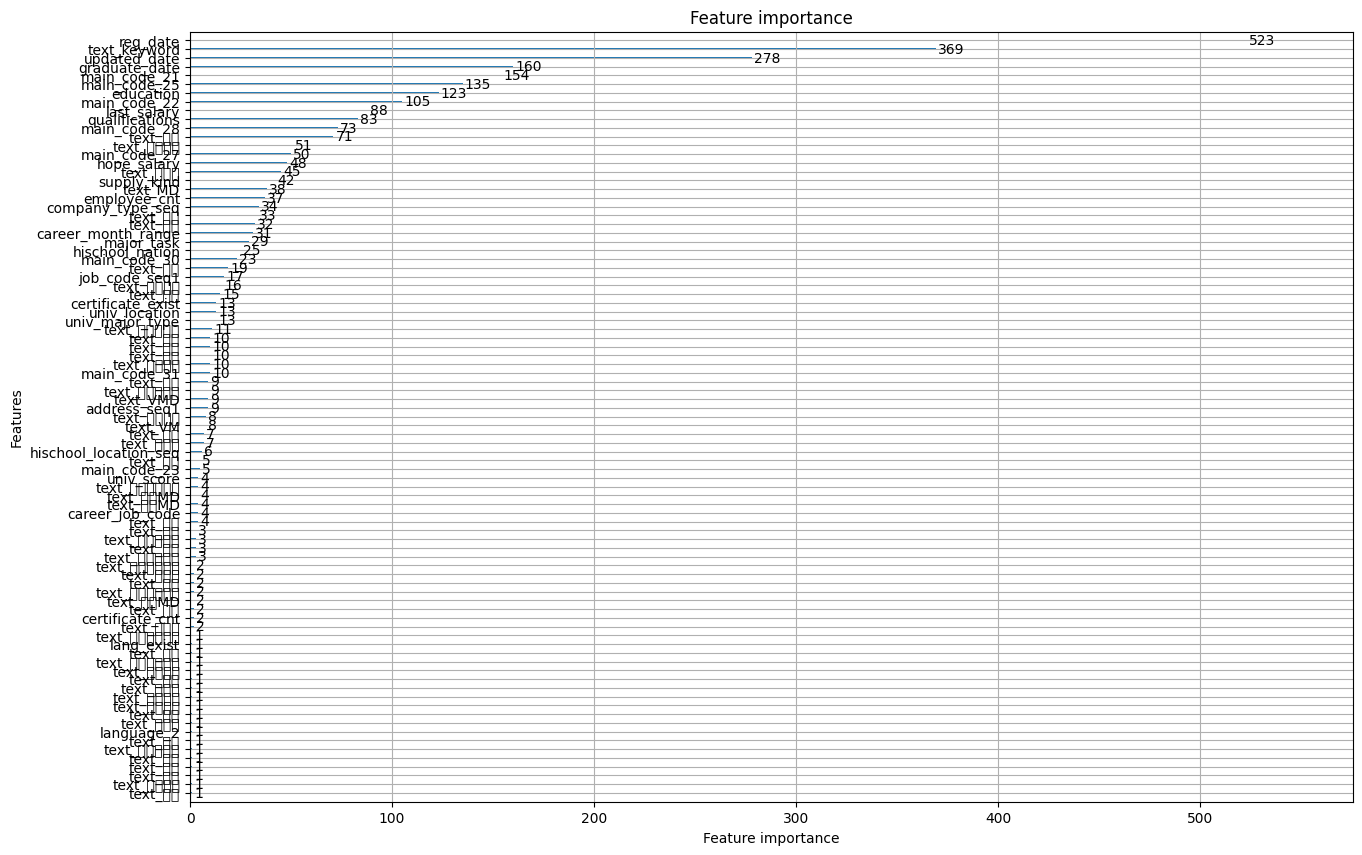

In [ ]:
fig, ax  = plt.subplots(figsize = (15,10))
plot_importance(model_V0,ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# confusion_matrix(실제값, 예측값)
# normalize="true" -> 확률값으로 변경!!
conf_mx = confusion_matrix(y_te, pred_te, normalize="true")
conf_mx

array([[0.61011554, 0.38988446],
       [0.22152794, 0.77847206]])

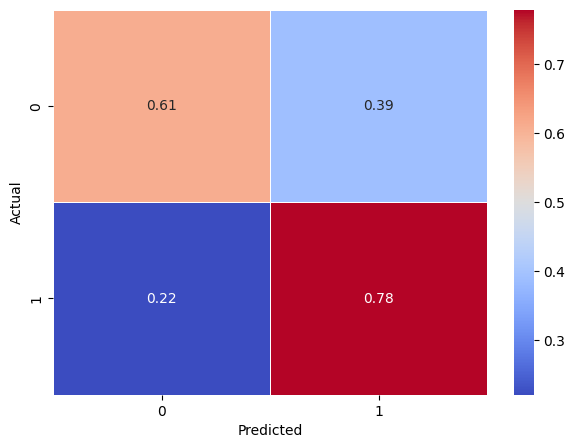

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# annot=True -> 수치데이터 표시
# cmap -> 히트맵 컬러정의
# linewidth -> 선 두께
sns.heatmap(conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 예측

In [ ]:
best_model = model_V0

In [ ]:
all_recommendations = []

for resume in tqdm(resume_pool):
#for resume in tqdm(['U00001', 'U00002','U00003', 'U00004', 'U00005']):
    # 2. 임시 데이터프레임 생성
    _df_temp = pd.DataFrame({'resume_seq': [resume] * len(recruitment)})

    # 3. 전체 공고 seq를 붙임
    _df_temp['recruitment_seq'] = list(recruitment_pool)
    _df_temp.head()

    # 4. 임시 데이터프레임에 feature들 merge. 이후 구직자, 공고 id 제거 및 모델 학습
    _df_train = pd.merge(_df_temp, merged_recruitment, on='recruitment_seq', how='left')
    _df_train = pd.merge(_df_train, merged_resume, on='resume_seq', how='left')
    _df_train_drop_col = ['recruitment_seq', 'resume_seq']
    _df_train.drop(_df_train_drop_col, axis = 1, inplace=True)

    # 5. 예측 확률 계산
    pred_proba = best_model.predict_proba(_df_train)[:,1]

    # 6. 임시 데이터프레임에 예측 확률 추가하고 상위로 정렬
    _df_temp['prediction'] = pred_proba
    _df_temp = _df_temp.sort_values(by='prediction', ascending=False)

    # 7. 현재 구직자의 이미 지원한 공고 가져오기
    already_applied_jobs = apply_train[apply_train['resume_seq'] == resume]['recruitment_seq'].values

    # 8. 임시 데이터프레임에서 이미 지원한 공고를 제거
    _df_temp = _df_temp[~_df_temp['recruitment_seq'].isin(already_applied_jobs)]

    # 상위 5개 추천 (이미 지원한 공고를 제외한 상위 5개)
    top_recommendations = _df_temp.head(5)

    # 결과 출력 또는 활용
    all_recommendations.append(top_recommendations)

final_recommendations = pd.concat(all_recommendations, ignore_index=True)
final_recommendations = final_recommendations[['resume_seq', 'recruitment_seq']]
final_recommendations = final_recommendations.sort_values(by='resume_seq')
final_recommendations


# Result 저장 (Submission)

In [ ]:
final_recommendations = final_recommendations[['resume_seq', 'recruitment_seq']]

In [ ]:
recall5(apply_train, final_recommendations)

In [ ]:
now = datetime.now() + timedelta(hours=9)
formatted_time = now.strftime("%Y%m%d_%H%M")

In [ ]:
final_recommendations.to_csv(args.default_path+ '/result/submission_'+formatted_time+'.csv', index=False)